<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Workflow (Clean-Clean) Entity Resolution</b> </font>
   <hr>
</div>

In [29]:
import os
import sys
import pandas as pd
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Reading

In [30]:
from pyjedai.datamodel import Data

data = Data(
    dataset_1=pd.read_csv("./data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=pd.read_csv("./data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=pd.read_csv("./data/ccer/D2/gt.csv", sep='|', engine='python'),
)

## WorkFlow

In [31]:
from pyjedai.workflow import WorkFlow, compare_workflows
from pyjedai.block_building import StandardBlocking, QGramsBlocking, ExtendedQGramsBlocking, SuffixArraysBlocking, ExtendedSuffixArraysBlocking
from pyjedai.block_cleaning import BlockFiltering, BlockPurging
from pyjedai.comparison_cleaning import WeightedEdgePruning, WeightedNodePruning, CardinalityEdgePruning, CardinalityNodePruning, BLAST, ReciprocalCardinalityNodePruning, ReciprocalWeightedNodePruning, ComparisonPropagation
from pyjedai.matching import EntityMatching
from pyjedai.clustering import ConnectedComponentsClustering

In [32]:
w = WorkFlow(
    block_building = dict(
        method=QGramsBlocking, 
        params=dict(qgrams=3)
    ),
    block_cleaning = [
        dict(
            method=BlockFiltering, 
            params=dict(ratio=0.8)
        ),
        dict(
            method=BlockPurging, 
            params=dict(smoothing_factor=1.025)
        )
    ],
    comparison_cleaning = dict(method=CardinalityEdgePruning),
    entity_matching = dict(
        method=EntityMatching, 
        params=dict(
            metric='edit_distance',
            similarity_threshold=0.5,
        )
    ),
    clustering = dict(method=ConnectedComponentsClustering),
    name="Worflow-Test"
)

In [33]:
w.run(data, verbose=True)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 3
Runtime: 2.9366 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.02% 
	Recall:       100.00%
	F1-score:       0.04%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
***************************************************************************************************************************
                                         Μethod:  Block Filtering
************************************************************************************

In [34]:
w.to_df()

,Algorithm,F1,Recall,Precision,Runtime (sec),Params
0,Q-Grams Blocking,0.041558,100.000000,0.020784,2.936595,{'Q-Gramms': 3}
1,Block Filtering,0.063146,100.000000,0.031583,1.677380,{'Ratio': 0.8}
2,Block Purging,0.067268,100.000000,0.033645,0.103580,"{'Smoothing factor': 1.025, 'Max Comparisons p..."
3,Cardinality Edge Pruning,3.467367,97.490706,1.765072,38.182795,"{'Node centric': False, 'Weighting scheme': 'JS'}"
4,Entity Matching,0.556070,0.278810,100.000000,1688.951456,"{'Tokenizer': 'white_space_tokenizer', 'Metric..."
5,Connected Components Clustering,0.556070,0.278810,100.000000,0.000000,{}


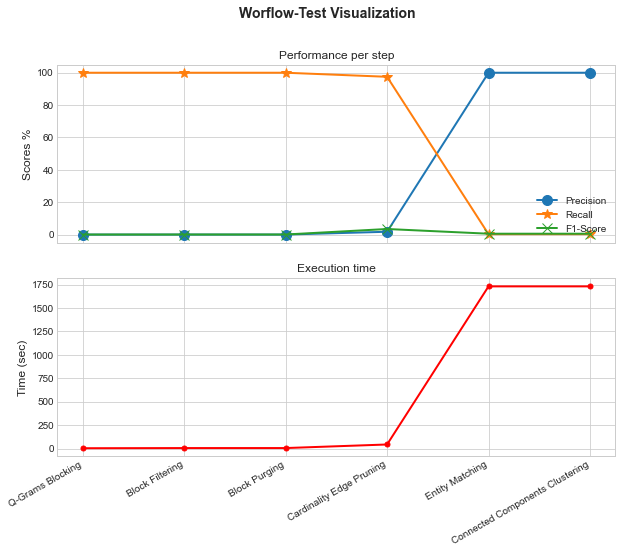

In [35]:
w.visualize()

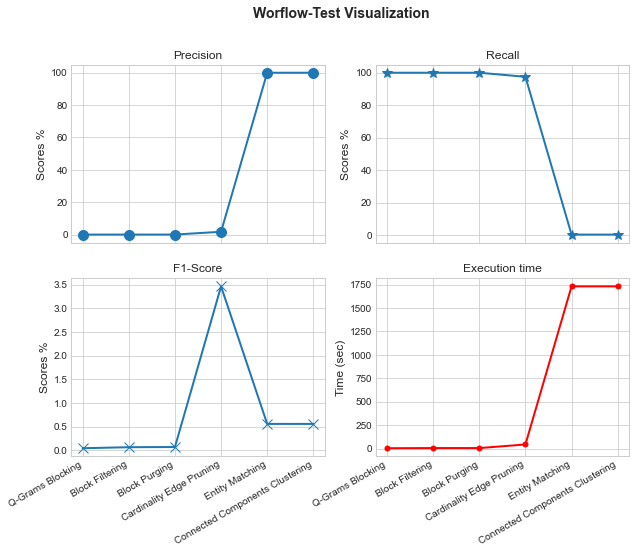

In [36]:
w.visualize(separate=True)

# Predefined workflows (best & default)

In [37]:
from pyjedai.workflow import (
    get_best_blocking_workflow_ccer, 
    get_best_blocking_workflow_der, 
    get_default_blocking_workflow_ccer
)
get_best_blocking_workflow_ccer().run(data, verbose=True)

***************************************************************************************************************************
                                         Μethod:  Standard Blocking
***************************************************************************************************************************
Method name: Standard Blocking
Parameters: 
Runtime: 0.3964 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.12% 
	Recall:        99.81%
	F1-score:       0.24%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
***************************************************************************************************************************
                                         Μethod:  Block Purging
*************************************************************************************************

In [38]:
get_default_blocking_workflow_ccer().run(data, verbose=True)

***************************************************************************************************************************
                                         Μethod:  Standard Blocking
***************************************************************************************************************************
Method name: Standard Blocking
Parameters: 
Runtime: 0.6960 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.12% 
	Recall:        99.81%
	F1-score:       0.24%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
***************************************************************************************************************************
                                         Μethod:  Block Purging
*************************************************************************************************

## Multiple workflows - Comparison

In [39]:
w1 = WorkFlow(
    block_building = dict(
        method=QGramsBlocking, 
        params=dict(qgrams=4),
        attributes_1=['name'],
        attributes_2=['name']
    ),
    block_cleaning = [
        dict(
            method=BlockFiltering, 
            params=dict(ratio=0.6)
        ),
        dict(
            method=BlockPurging, 
            params=dict(smoothing_factor=1.025)
        )
    ],
    comparison_cleaning = dict(method=CardinalityEdgePruning),
    entity_matching = dict(
        method=EntityMatching, 
        params=dict(
            metric='dice',
            similarity_threshold=0.5,
        )
    ),
    clustering = dict(method=ConnectedComponentsClustering)
)
w1.run(data, verbose=True, workflow_tqdm_enable=False)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 4
Runtime: 0.4156 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.17% 
	Recall:       100.00%
	F1-score:       0.34%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
***************************************************************************************************************************
                                         Μethod:  Block Filtering
************************************************************************************

In [40]:
w2 = WorkFlow(
    block_building = dict(
        method=QGramsBlocking, 
        params=dict(qgrams=4),
        attributes_1=['name'],
        attributes_2=['name']
    ),
    block_cleaning = [
        dict(
            method=BlockFiltering, 
            params=dict(ratio=0.6)
        ),
        dict(
            method=BlockPurging, 
            params=dict(smoothing_factor=1.025)
        )
    ],
    comparison_cleaning = dict(method=CardinalityEdgePruning),
    entity_matching = dict(
        method=EntityMatching,
        params=dict(
            metric='edit_distance',
            similarity_threshold=0.5,
        )
    ),
    clustering = dict(method=ConnectedComponentsClustering)
)
w2.run(data, verbose=True, workflow_tqdm_enable=False)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 4
Runtime: 0.4468 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.17% 
	Recall:       100.00%
	F1-score:       0.34%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
***************************************************************************************************************************
                                         Μethod:  Block Filtering
************************************************************************************

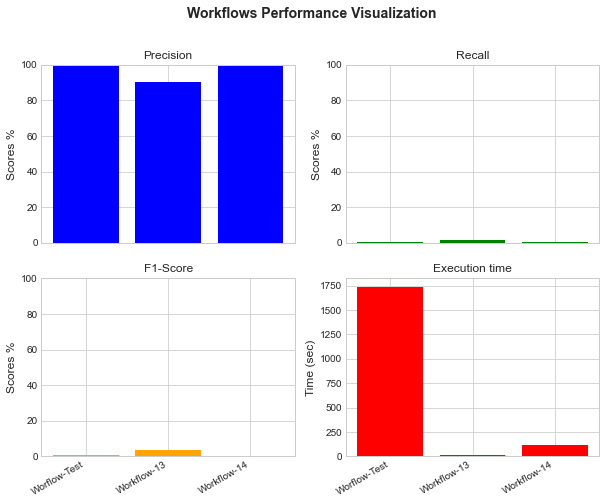

,Name,F1,Recall,Precision,Runtime (sec)
0,Worflow-Test,0.556070,0.278810,100.00000,1736.835522
1,Workflow-13,3.463993,1.765799,90.47619,18.682373
2,Workflow-14,0.371058,0.185874,100.00000,115.524339


In [41]:
compare_workflows([w, w1, w2], with_visualization=True)

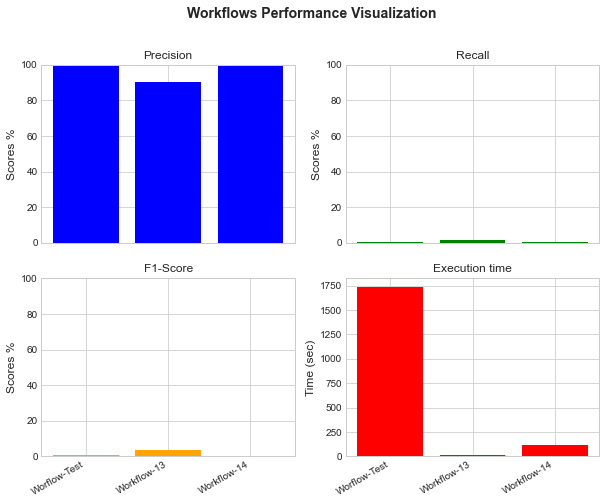

,Name,F1,Recall,Precision,Runtime (sec)
0,Worflow-Test,0.556070,0.278810,100.00000,1736.835522
1,Workflow-13,3.463993,1.765799,90.47619,18.682373
2,Workflow-14,0.371058,0.185874,100.00000,115.524339


In [42]:
compare_workflows([w, w1, w2], with_visualization=True)